In [8]:
import argparse
import os
import sys
import h5py
from spectral import * 
import numpy as np
import glob
import warnings
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import json
import glob
import multiprocessing
warnings.filterwarnings('ignore')
import cv2
import re
import hypers as hp
import subprocess
from detecto import core, utils, visualize
from detecto.utils import read_image, filter_top_predictions
import matplotlib.pyplot as plt
from PIL import Image

In [15]:
# --------------------------------------------------
def detect_panels(image, model_path, hypercube):

    model = core.Model.load(model_path, ['panel'])
    image = (image * 255).astype(np.uint8)
    plt.figure()
    plt.imshow(image)
    plt.show()
    predictions = model.predict(image)
    
    labels, boxes, scores = predictions

    copy = image.copy()
    print(scores)
    panel_dict = {}
    
    for i, box in enumerate(boxes):
        if scores[i] >= 0.9:
            min_x, min_y, max_x, max_y = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            ml = [min_y, min_x, max_y, max_x]

            start_point = (min_x, max_y)
            end_point = (max_x, min_y)

            new_img = copy[min_y:max_y, min_x:max_x, :]
            
            panel_cube = hypercube[min_y:max_y, min_x:max_x, :]
            (m, c) = kmeans(panel_cube, 5, 50)
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(new_img);
            ax[1].imshow(m);
            plt.show()
            plt.close()

            white_ref = c[4]
            center = image.shape[1]//2

            panel_side = 'east' if max_x and min_x > center else 'west'

            panel_dict[panel_side] = white_ref
            


    return panel_dict

# --------------------------------------------------
def generate_save_rgb(img, wavelength_floats):
    
    r_band = closest(wavelength_floats, 669)[0]
    g_band = closest(wavelength_floats, 549)[0]
    b_band = closest(wavelength_floats, 474)[0]
    
    rgb = get_rgb(img, bands=[r_band, g_band, b_band])
    
    return rgb

# --------------------------------------------------
def closest(lst, K):

    return min(enumerate(lst), key=lambda x: abs(x[1]-K))

# --------------------------------------------------
def apply_mask(f, array):
    mask = np.array(f['ndvi_mask'])
    array[:,:,:][np.where(mask==0)] = 0
    
    return array

# --------------------------------------------------
def get_panel_reflectance(panel_dict):
    
    if len(panel_dict) == 2:
        west = panel_dict['west'].mean()
        east = panel_dict['east'].mean()
        white_ref = panel_dict['west'] if west > east else panel_dict['east']

    else:
        key = list(panel_dict.keys())[0]
        white_ref = panel_dict[key]
        
    return white_ref

# --------------------------------------------------
def calculate_reflectance(spectra, white_reference):
    
    corrected_spectra = np.divide(spectra,
                                  white_reference)

    return corrected_spectra*100

# --------------------------------------------------

In [10]:

model_path = '/scratch/ag2pi_workshop/model_weights_panel_2021-06-18_transform.pth'

f = h5py.File('/scratch/ag2pi_workshop/sample.h5', 'r')

ImageView object:
  Display bands       :  [0, 470.0, 939]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2658.0]
    G: [340.0, 13453.0]
    B: [32.0, 698.0]

<Figure size 2160x1800 with 0 Axes>

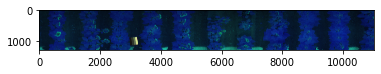

In [14]:
plt.figure(figsize=(30,25))
imshow(f['hyperspectral'][:,:,:])

In [16]:
wavelength_floats = [float(string) for string in f.attrs['wavelength']]

In [17]:
rgb = generate_save_rgb(f['hyperspectral'], wavelength_floats)

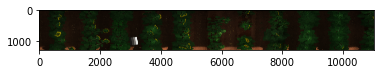

tensor([0.9330, 0.3783, 0.1344, 0.0832])


spectral:INFO: k-means iteration 1 - 42317 pixels reassigned.
spectral:INFO: k-means iteration 2 - 1726 pixels reassigned.
spectral:INFO: k-means iteration 3 - 864 pixels reassigned.
spectral:INFO: k-means iteration 4 - 360 pixels reassigned.
spectral:INFO: k-means iteration 5 - 217 pixels reassigned.
spectral:INFO: k-means iteration 6 - 141 pixels reassigned.
spectral:INFO: k-means iteration 7 - 75 pixels reassigned.
spectral:INFO: k-means iteration 8 - 35 pixels reassigned.
spectral:INFO: k-means iteration 9 - 30 pixels reassigned.
spectral:INFO: k-means iteration 10 - 18 pixels reassigned.
spectral:INFO: k-means iteration 11 - 10 pixels reassigned.
spectral:INFO: k-means iteration 12 - 3 pixels reassigned.
spectral:INFO: k-means iteration 13 - 3 pixels reassigned.
spectral:INFO: k-means iteration 14 - 2 pixels reassigned.
spectral:INFO: k-means iteration 15 - 1 pixels reassigned.
spectral:INFO: k-means iteration 16 - 1 pixels reassigned.
spectral:INFO: k-means iteration 17 - 0 pixel

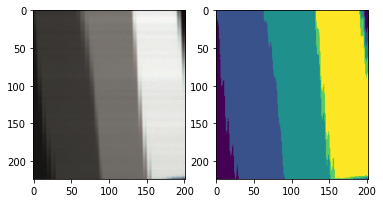

CPU times: user 11.6 s, sys: 240 ms, total: 11.8 s
Wall time: 11.8 s


In [20]:
%%time
panel_dict = detect_panels(rgb, model_path, f['hyperspectral'])

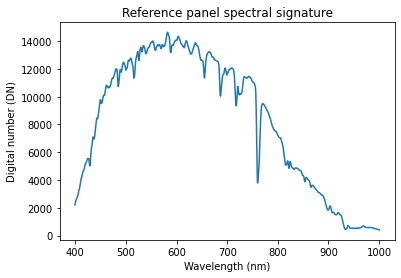

In [40]:
white_ref = get_panel_reflectance(panel_dict)
sns.lineplot(x=f.attrs['wavelength'].astype(float),
             y=white_ref)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Digital number (DN)')
plt.title('Reference panel spectral signature');

In [23]:
mask = apply_mask(f, f['hyperspectral'][:,:,:])

In [31]:
# imshow(mask[:,8300:9400,:])

ImageView object:
  Display bands       :  [0, 470.0, 939]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 335.0]
    G: [0.0, 4217.0]
    B: [0.0, 540.0]

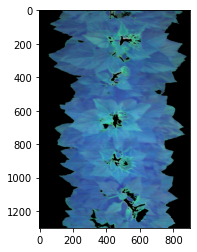

In [32]:
imshow(mask[:,9400:10300,:])

In [33]:
(m, c) = kmeans(mask[:,9400:10300,:], 3, 100)

spectral:INFO: k-means iteration 1 - 811584 pixels reassigned.
spectral:INFO: k-means iteration 2 - 101167 pixels reassigned.
spectral:INFO: k-means iteration 3 - 72015 pixels reassigned.
spectral:INFO: k-means iteration 4 - 49451 pixels reassigned.
spectral:INFO: k-means iteration 5 - 34232 pixels reassigned.
spectral:INFO: k-means iteration 6 - 23876 pixels reassigned.
spectral:INFO: k-means iteration 7 - 17117 pixels reassigned.
spectral:INFO: k-means iteration 8 - 11837 pixels reassigned.
spectral:INFO: k-means iteration 9 - 8425 pixels reassigned.
spectral:INFO: k-means iteration 10 - 6243 pixels reassigned.
spectral:INFO: k-means iteration 11 - 4593 pixels reassigned.
spectral:INFO: k-means iteration 12 - 3277 pixels reassigned.
spectral:INFO: k-means iteration 13 - 2338 pixels reassigned.
spectral:INFO: k-means iteration 14 - 1618 pixels reassigned.
spectral:INFO: k-means iteration 15 - 1185 pixels reassigned.
spectral:INFO: k-means iteration 16 - 889 pixels reassigned.
spectral

ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2.0]
    G: [0.0, 2.0]
    B: [0.0, 2.0]

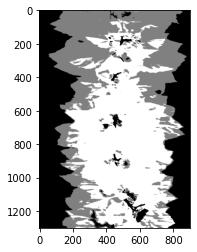

In [34]:
imshow(m)

In [41]:
soil_ref = calculate_reflectance(c[0], white_ref)
shaded_ref = calculate_reflectance(c[1], white_ref)
sunlit_ref = calculate_reflectance(c[2], white_ref)

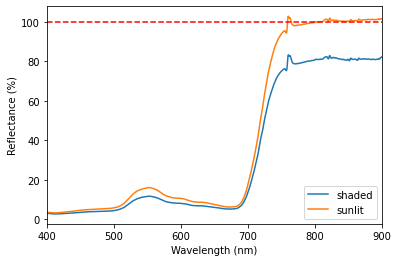

In [44]:
sns.lineplot(x=f.attrs['wavelength'].astype(float),
             y= shaded_ref)

sns.lineplot(x=f.attrs['wavelength'].astype(float),
             y= sunlit_ref)

plt.legend(['shaded', 'sunlit'])
plt.axhline(y=100, color='r', linestyle='--')
plt.xlim([400,900])
plt.xlabel(f'Wavelength (nm)')
plt.ylabel(f'Reflectance (%)');